# Code example 0a: AlphaFold2 (ColabFold)

<a href="https://colab.research.google.com/github/BioGeMT/MALTAomics-Summer-School/blob/main/Day4_WorkshopVII_DeepLearningForProteinStructure/maltaomics_ex0a_alphafold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Downloading an already existing structure from [AlphaFold database](https://alphafold.ebi.ac.uk/ ):

In [1]:
#############################################################################
# TODO: Find a UniProt ID of some protein that has a structure available in #
# the AlphaFold database: https://alphafold.ebi.ac.uk/                      #
#############################################################################

UNIPROT_ID = 'O15552' #'P31456' #'A0A3B3QWR5'
PATH = '/content/'

In [2]:
import requests

def download_af_structure(uniprot_id):
  try:
    # download 3D structure based on UniProt ID:
    response = requests.get(f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb')
    if not response.ok or response.text == 'N/A':
      print(f'AF structure not found for {uniprot_id}.')
    structure = response.text

    # save the downloaded structure to a PDB file:
    path_file = f'{PATH}/af-{uniprot_id}.pdb'
    with open(path_file, 'w') as f:
      f.write(structure)
    return path_file

  except:
    print(f'Exception {uniprot_id}')
  return ''

structure_path = download_af_structure(UNIPROT_ID)
structure_path

'/content//af-O15552.pdb'

We can visualize the structure in an interactive way:

In [3]:
!pip3 install -qU py3Dmol

In [4]:
import py3Dmol

# https://william-dawson.github.io/using-py3dmol.html
def display_structure(pdb_path):
  view = py3Dmol.view()
  view.addModel(open(pdb_path, 'r').read(),'pdb')

  # view.setStyle({'cartoon':{'color': 'gray'}})
  # view.setStyle({'cartoon':{'color': 'spectrum'}})

  # colour by pLDDT:
  view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})

  view.zoomTo()
  view.show()

display_structure(structure_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 2. Predicting a structure from an amino acid sequence:

We will extract the amino acid sequence from a PDB file:

In [5]:
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 16.5 MB/s eta 0:00:00


In [6]:
from Bio import SeqIO

def get_aa_seq(pdb_path):
  # (more code because SeqIO.parse returns a generator in case the input file
  # contains more than one records)
  aa_seq = []
  for record in SeqIO.parse(pdb_path, 'pdb-atom'):
    aa_seq.append(record.seq)

  if len(aa_seq) == 1:
    aa_seq = str(aa_seq[0])

  return aa_seq

aa_seq = get_aa_seq(structure_path)
aa_seq

/usr/local/lib/python3.10/dist-packages/Bio/SeqIO/PdbIO.py:322: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(


'MLPDWKSSLILMAYIIIFLTGLPANLLALRAFVGRIRQPQPAPVHILLLSLTLADLLLLLLLPFKIIEAASNFRWYLPKVVCALTSFGFYSSIYCSTWLLAGISIERYLGVAFPVQYKLSRRPLYGVIAALVAWVMSFGHCTIVIIVQYLNTTEQVRSGNEITCYENFTDNQLDVVLPVRLELCLVLFFIPMAVTIFCYWRFVWIMLSQPLVGAQRRRRAVGLAVVTLLNFLVCFGPYNVSHLVGYHQRKSPWWRSIAVVFSSLNASLDPLLFYFSSSVVRRAFGRGLQVLRNQGSSLLGRRGKDTAEGTNEDRGVGQGEGMPSSDFTTE'

Using **ColabFold** *(publicly available version of AlphaFold which can run on Google Colab)* with default parameters to predict the structure:

(Simplified from https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb#scrollTo=11l8k--10q0C, takes ~10 minutes.)

In [7]:
!pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'
!pip install --upgrade dm-haiku

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.6/225.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.0/242.0 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: dm-haiku
    Found existing installation: dm-haiku 0.0.9
    Uninstalling dm-haiku-0.0.9:
      Successfully uninstalled dm-haiku-0.0.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cola

In [8]:
%%time
import os

os.system('!ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold')
os.system('!ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold')
# patch for jax > 0.3.25
os.system('sed -i "s/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g" alphafold/model/modules.py')

CPU times: user 1.09 ms, sys: 19 µs, total: 1.1 ms
Wall time: 13.4 ms


512

Running ColabFold:

In [9]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
from pathlib import Path

# prepare input:
queries_path = f'{PATH}/{UNIPROT_ID}.csv'
with open(queries_path, 'w') as text_file:
  text_file.write(f'id,sequence\n{UNIPROT_ID},{aa_seq}')

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, 'auto')

print(queries)
print(is_complex)
print(model_type)

# run colabfold:
download_alphafold_params(model_type, Path('.'))
results = run(
    queries=queries,
    result_dir=PATH,
    data_dir=Path('.'),
    keep_existing_results=False,
    num_models=1,
    is_complex=is_complex
)
results

[('O15552', 'MLPDWKSSLILMAYIIIFLTGLPANLLALRAFVGRIRQPQPAPVHILLLSLTLADLLLLLLLPFKIIEAASNFRWYLPKVVCALTSFGFYSSIYCSTWLLAGISIERYLGVAFPVQYKLSRRPLYGVIAALVAWVMSFGHCTIVIIVQYLNTTEQVRSGNEITCYENFTDNQLDVVLPVRLELCLVLFFIPMAVTIFCYWRFVWIMLSQPLVGAQRRRRAVGLAVVTLLNFLVCFGPYNVSHLVGYHQRKSPWWRSIAVVFSSLNASLDPLLFYFSSSVVRRAFGRGLQVLRNQGSSLLGRRGKDTAEGTNEDRGVGQGEGMPSSDFTTE', None)]
False
alphafold2_ptm


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:01 remaining: 00:00]


{'rank': [['rank_001_alphafold2_ptm_model_1_seed_000']],
 'metric': [[{'mean_plddt': 82.375,
    'ptm': 0.794921875,
    'print_line': ' pLDDT=82.4 pTM=0.795'}]]}

Some optional parameters worth mentioning:

| Parameter | Possible values | Description |
|-|-|-|
| `msa_mode` | ["mmseqs2_uniref_env", "mmseqs2_uniref", "single_sequence", "custom"] | - |
| `pair_mode` | ["unpaired_paired", "paired", "unpaired"] | Unpaired_paired: pair sequences from same species + unpaired MSA; unpaired: seperate MSA for each chain; paired: only use paired sequences. |
| `model_type` | ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"] | Auto: alphafold2_ptm used for monomer prediction and alphafold2_multimer_v3 for complex prediction. |
| `num_recycles` | ["auto", "0", "1", "3", "6", "12", "24", "48"] | - |
| `recycle_early_stop_tolerance` | ["auto", "0.0", "0.5", "1.0"] | Auto: 20 recycles used if model_type=alphafold2_multimer_v3 (with tol=0.5),  else 3 recycles (with tol=0.0) |
| `pairing_strategy` | ["greedy", "complete"] | Greedy: pair any taxonomically matching subsets; complete: all sequences have to match in one line. |
| `max_msa` | ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"] | - |
| `num_seeds` | [1, 2, 4, 8, 16] | - |
| `use_dropout` | True, False | - |
| `num_recycles` | None if num_recycles == 'auto' else int(num_recycles) | - |
| `max_msa` | if max_msa == 'auto': max_msa = None | Decrease to increase uncertainity. |
| `dpi` | int | Image resolution. |
| `template_mode` | [None, "pdb100", "custom"] | None: no template information is used; pdb100: detect templates in pdb100; custom: upload and search own templates (PDB/ mmCIF format) |
| `num_relax` | int | How many of the top ranked structures to relax^ using amber. |
| `num_models` | int | How many structures will be generated. |

^structural relaxation == slow molecular rearrangement

In [10]:
predicted_structure_path = f'{PATH}/{UNIPROT_ID}_unrelaxed_{results["rank"][0][0]}.pdb'
predicted_structure_path

'/content//O15552_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb'

Display the predicted structure:

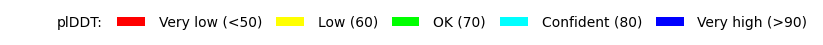

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
from colabfold.colabfold import plot_plddt_legend

plot_plddt_legend().show()
display_structure(predicted_structure_path)

## 3. Compare the two structures - align them minimizing RMSD:

Source: https://gist.github.com/andersx/6354971

**Root Mean Square Deviation** ([RMSD](https://en.wikipedia.org/wiki/Root-mean-square_deviation_of_atomic_positions))

== measure of the average distance between the atoms (usually the backbone atoms) of superimposed proteins


$$ RMSD = \sqrt{{{1} \over {N}} \sum_{i=1}^{N} \delta_i^2} $$

In [12]:
import Bio.PDB

def get_atoms_to_be_aligned(some_structure, atoms_range):
  atoms = []
  for chain in some_structure:
    # to find proper atoms iterate over all residues (amino acids) in the chain
    for residue in chain:
      if residue.get_id()[1] in atoms_range:
        atoms.append(residue['CA'])  # append CA atom to list -- C alpha is the
                                     # position of the functional group (what
                                     # responsible for the molecule's chemical
                                     # characteristics)
  return atoms

def align_two_structures(reference_structure_path, sample_structure_path):
  ref_str_len = len(get_aa_seq(reference_structure_path))
  sample_str_len = len(get_aa_seq(sample_structure_path))
  max_str_len = min(ref_str_len, sample_str_len)

  atoms_to_be_aligned = range(1, max_str_len)

  pdb_parser = Bio.PDB.PDBParser()
  ref_structure = pdb_parser.get_structure('reference', reference_structure_path)[0]
  sample_structure = pdb_parser.get_structure('sample', sample_structure_path)[0]

  # make a list of the atoms (in the structures) you wish to align
  # (here we use CA atoms whose index is in the specified range)
  ref_atoms = get_atoms_to_be_aligned(ref_structure, atoms_to_be_aligned)
  sample_atoms = get_atoms_to_be_aligned(sample_structure, atoms_to_be_aligned)

  # initiate the superimposer
  super_imposer = Bio.PDB.Superimposer()
  super_imposer.set_atoms(ref_atoms, sample_atoms)
  super_imposer.apply(sample_structure.get_atoms())

  # RMSD
  print(super_imposer.rms)

  # save the aligned version of the sample structure
  io = Bio.PDB.PDBIO()
  io.set_structure(sample_structure)
  aligned_structure_path = f'{PATH}/aligned.pdb'
  io.save(aligned_structure_path)
  return aligned_structure_path

aligned_structure_path = align_two_structures(structure_path, predicted_structure_path)
aligned_structure_path

/usr/local/lib/python3.10/dist-packages/Bio/SeqIO/PdbIO.py:322: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/Bio/SeqIO/PdbIO.py:322: BiopythonParserWarning: 'HEADER' line not found; can't determine PDB ID.
  warnings.warn(


8.007394033982825


'/content//aligned.pdb'

Display the AlphaFold (orange) and predicted (blue) structures before alignment:

In [13]:
def display_two_structures(pdb_path_reference, pdb_path_sample):
  view = py3Dmol.view()
  view.addModel(open(pdb_path_reference, 'r').read(), 'pdb')
  view.addModel(open(pdb_path_sample, 'r').read(), 'pdb')
  view.setStyle({'cartoon': {'color': 'orange'}})
  # (the predicted structure is blue, https://william-dawson.github.io/using-py3dmol.html)
  view.setStyle({'model': -1}, {'cartoon': {'color': 'blue'}})
  view.zoomTo()
  view.show()

display_two_structures(structure_path, predicted_structure_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Display the AlphaFold (orange) and predicted (blue) structures after alignment:

In [14]:
display_two_structures(structure_path, aligned_structure_path)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Are we getting the same results for our `amino acid sequence -> 3D structure` prediction as what is in the AF2 database - why?